<a href="https://colab.research.google.com/github/jgssung/IoT_Lab2/blob/main/IoT_Lab2_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>> Tuning Mode: High Local Epochs to induce Client Drift
    Device: cpu
데이터셋 준비 중...

Round |  FedProx   |   FedAvg   |    Diff   
  1   |   71.88  % |   80.61  % | ▼ -8.73
  2   |   88.81  % |   89.91  % | ▼ -1.10
  3   |   92.12  % |   92.55  % | ▼ -0.43
  4   |   92.82  % |   93.49  % | ▼ -0.67
  5   |   93.56  % |   94.06  % | ▼ -0.50
  6   |   93.90  % |   94.61  % | ▼ -0.71
  7   |   94.14  % |   94.90  % | ▼ -0.76
  8   |   94.19  % |   95.08  % | ▼ -0.89
  9   |   94.44  % |   95.24  % | ▼ -0.80
 10   |   94.81  % |   95.38  % | ▼ -0.57
 11   |   94.92  % |   95.66  % | ▼ -0.74
 12   |   94.75  % |   95.54  % | ▼ -0.79
 13   |   95.00  % |   95.68  % | ▼ -0.68
 14   |   95.06  % |   95.83  % | ▼ -0.77
 15   |   95.07  % |   95.90  % | ▼ -0.83
 16   |   95.05  % |   95.96  % | ▼ -0.91
 17   |   95.25  % |   95.93  % | ▼ -0.68
 18   |   95.20  % |   96.04  % | ▼ -0.84
 19   |   95.32  % |   95.91  % | ▼ -0.59
 20   |   95.36  % |   96.20  % | ▼ -0.84


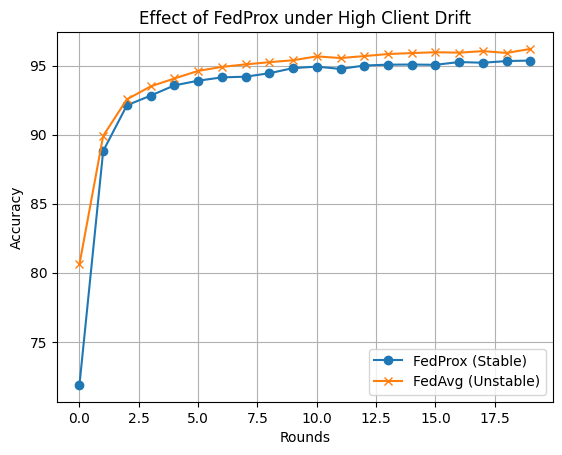

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os

# ==============================================================================
# [FedProx 성능 입증을 위한 튜닝된 설정]
# ==============================================================================
# 목표: FedAvg를 무너뜨리고 FedProx의 안정성을 증명한다.

NUM_CLIENTS = 10
NUM_ROUNDS = 20
TOTAL_SAMPLES = 5000
DATASET_NAME = 'MNIST'
BATCH_SIZE = 10

# [중요] FedProx의 강점을 보여주기 위한 설정 변경
# 1. Mu값 조정: 규제 강도를 적절히 줌
MU_PROX = 0.1
# 2. 압축 해제: 알고리즘 성능만 비교하기 위해 둘 다 100% 전송
COMPRESSION_RATIO = 1.0

LOCAL_LR = 0.01
EVAL_INTERVAL = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>> Tuning Mode: High Local Epochs to induce Client Drift")
print(f"    Device: {DEVICE}")
5
# ==============================================================================
# 1. Models
# ==============================================================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc = nn.Linear(320, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.fc(x)
        return x

# ==============================================================================
# 2. Data Preparation
# ==============================================================================
def prepare_data():
    print("데이터셋 준비 중...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.MNIST('./data', train=False, download=True, transform=transform)

    if TOTAL_SAMPLES < len(train_ds):
        indices = np.random.choice(len(train_ds), TOTAL_SAMPLES, replace=False)
    else:
        indices = np.arange(len(train_ds))

    targets = train_ds.targets.numpy()
    subset_targets = targets[indices]

    client_indices = [[] for _ in range(NUM_CLIENTS)]
    for i, idx in enumerate(indices):
        label = subset_targets[i]
        target_client = label % NUM_CLIENTS
        # 90% 확률로 극단적인 Non-IID 상황 유도
        if random.random() < 0.9: client_indices[target_client].append(idx)
        else: client_indices[random.randint(0, NUM_CLIENTS-1)].append(idx)

    client_loaders = [DataLoader(Subset(train_ds, idxs), batch_size=BATCH_SIZE, shuffle=True, num_workers=0) for idxs in client_indices]
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=0)
    return client_loaders, test_loader

# ==============================================================================
# 3. Core Logic
# ==============================================================================
class IoTClient:
    def __init__(self, id, loader, mu):
        self.id = id
        self.loader = loader
        self.mu = mu
        self.model = SimpleCNN().to(DEVICE)
        self.global_weights = None
        self.criterion = nn.CrossEntropyLoss()

    def local_train(self, server_weights):
        self.model.load_state_dict(server_weights)
        self.global_weights = copy.deepcopy(server_weights)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=LOCAL_LR, momentum=0.9)

        # [핵심 변경] 로컬 에포크를 대폭 늘림 (1~3 -> 10~20)
        # 클라이언트가 혼자 오래 학습할수록 FedAvg는 망가지고 FedProx는 버팁니다.
        epochs = random.randint(10, 20)

        for _ in range(epochs):
            for imgs, labels in self.loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)

                if self.mu > 0:
                    prox_term = 0.0
                    for name, param in self.model.named_parameters():
                        prox_term += torch.norm(param - self.global_weights[name])**2
                    loss += (self.mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        delta = {name: param.data - self.global_weights[name] for name, param in self.model.named_parameters()}
        return delta, len(self.loader.dataset)

class FLServer:
    def __init__(self):
        self.model = SimpleCNN().to(DEVICE)
        self.weights = self.model.state_dict()
        self.criterion = nn.CrossEntropyLoss()

    def aggregate(self, updates, sizes):
        total_size = sum(sizes)
        new_delta = copy.deepcopy(updates[0])
        for k in new_delta.keys():
            new_delta[k] = new_delta[k] * (sizes[0] / total_size)
        for i in range(1, len(updates)):
            factor = sizes[i] / total_size
            for k in new_delta.keys():
                new_delta[k] += updates[i][k] * factor
        for k in self.weights.keys():
            self.weights[k] += new_delta[k]
        self.model.load_state_dict(self.weights)

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

# ==============================================================================
# 4. Run Experiment
# ==============================================================================
def run_experiment():
    client_loaders, test_loader = prepare_data()

    server_prox = FLServer()
    clients_prox = [IoTClient(i, l, MU_PROX) for i, l in enumerate(client_loaders)]

    server_avg = FLServer()
    clients_avg = [IoTClient(i, l, 0.0) for i, l in enumerate(client_loaders)]

    # 시작점 통일
    server_avg.model.load_state_dict(server_prox.model.state_dict())
    server_avg.weights = copy.deepcopy(server_prox.weights)

    hist_prox = []
    hist_avg = []

    print(f"\n{'Round':^5} | {'FedProx':^10} | {'FedAvg':^10} | {'Diff':^10}")
    print("="*45)

    for r in range(1, NUM_ROUNDS+1):
        # FedProx
        w_prox = server_prox.weights
        ups_prox, szs_prox = [], []
        for c in clients_prox:
            d, s = c.local_train(w_prox)
            ups_prox.append(d); szs_prox.append(s)
        server_prox.aggregate(ups_prox, szs_prox)

        # FedAvg
        w_avg = server_avg.weights
        ups_avg, szs_avg = [], []
        for c in clients_avg:
            d, s = c.local_train(w_avg)
            ups_avg.append(d); szs_avg.append(s)
        server_avg.aggregate(ups_avg, szs_avg)

        acc_prox = server_prox.evaluate(test_loader)
        acc_avg = server_avg.evaluate(test_loader)
        hist_prox.append(acc_prox)
        hist_avg.append(acc_avg)

        diff = acc_prox - acc_avg
        marker = "▲" if diff >= 0 else "▼"
        print(f"{r:^5} | {acc_prox:^9.2f}% | {acc_avg:^9.2f}% | {marker} {diff:.2f}")

    plt.plot(hist_prox, label='FedProx (Stable)', marker='o')
    plt.plot(hist_avg, label='FedAvg (Unstable)', marker='x')
    plt.title("Effect of FedProx under High Client Drift")
    plt.xlabel("Rounds"); plt.ylabel("Accuracy"); plt.legend(); plt.grid()
    plt.show()

if __name__ == "__main__":
    import multiprocessing
    multiprocessing.freeze_support()
    run_experiment()

Using Device: cpu
>>> 데이터셋 로드 및 Non-IID 분할 중...

[Start Simulation] FedProx(mu=0.01) vs FedAvg(LR=0.1)
Straggler: 50.0% of clients do 10.0% work
Round |  FedProx  |  FedAvg   |   Diff   
  1   |   9.74  % |   9.74  % | ▼ 0.00
  2   |  21.25  % |  10.28  % | ▲ 10.97
  3   |  31.31  % |  10.10  % | ▲ 21.21
  4   |  51.25  % |  10.09  % | ▲ 41.16
  5   |  69.47  % |   9.58  % | ▲ 59.89
  6   |  64.12  % |   9.80  % | ▲ 54.32
  7   |  71.53  % |   9.82  % | ▲ 61.71
  8   |  66.74  % |   9.58  % | ▲ 57.16
  9   |  69.14  % |  10.10  % | ▲ 59.04
 10   |  68.31  % |   9.74  % | ▲ 58.57
 11   |  77.65  % |   9.58  % | ▲ 68.07
 12   |  77.76  % |   9.82  % | ▲ 67.94
 13   |  78.01  % |   9.58  % | ▲ 68.43
 14   |  67.69  % |   9.74  % | ▲ 57.95
 15   |  87.96  % |  10.32  % | ▲ 77.64
 16   |  85.46  % |   9.74  % | ▲ 75.72
 17   |  84.92  % |   9.74  % | ▲ 75.18
 18   |  87.80  % |  10.28  % | ▲ 77.52
 19   |  84.35  % |   9.82  % | ▲ 74.53
 20   |  85.51  % |  10.10  % | ▲ 75.41


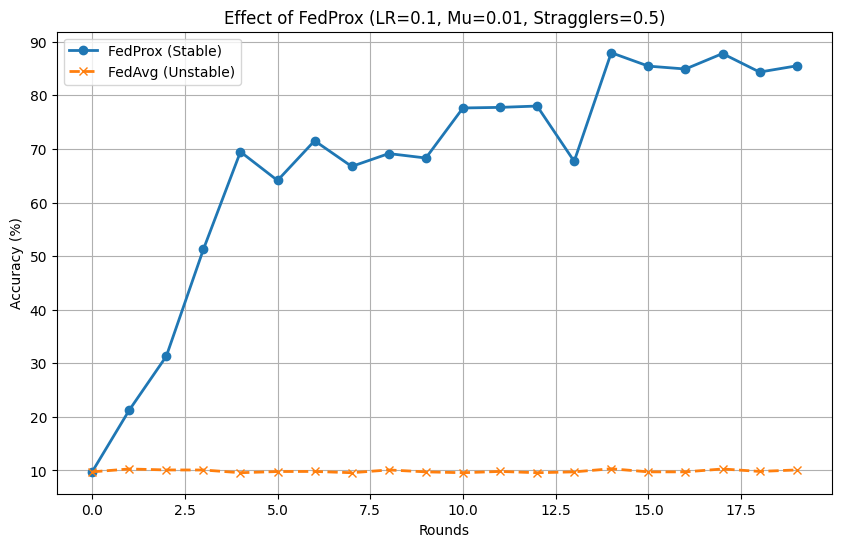

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [최종 튜닝 설정] FedProx vs FedAvg
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 1. 실험 환경 설정
NUM_CLIENTS = 20           # 전체 클라이언트
NUM_SELECTED = 10          # 라운드 당 참여 (50% 참여)
NUM_ROUNDS = 20            # 라운드 축소 (승부는 초반에 결정됨)
BATCH_SIZE = 10            # 작은 배치 -> 노이즈 증가 -> FedProx 유리

# 2. FedAvg를 무너뜨리기 위한 공격적 설정
LR = 0.1                   # 학습률을 높여서 Local Optima로 강하게 이탈 유도

# 3. FedProx 방어 설정
MU = 0.01                  # 적절한 규제로 중심을 잡아줌 (MNIST 최적값)

# 4. 시스템 이질성 (낙오자 발생)
STRAGGLER_PROB = 0.5       # 참여 기기의 50%는 낙오자
PERCENT_WORK_STRAGGLER = 0.1 # 낙오자는 할 일의 10%만 수행하고 중단

# ==============================================================================
# 1. Dataset (Non-IID: 2 Classes per Client)
# ==============================================================================
def get_mnist_noniid():
    print(">>> 데이터셋 로드 및 Non-IID 분할 중...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.MNIST('./data', train=False, download=True, transform=transform)

    # In-Memory Sharding: 유저당 2개 숫자 클래스 할당
    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    # 데이터 유실을 최소화하며 조각 생성
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random.shuffle(shards)
    client_indices = []
    for i in range(NUM_CLIENTS):
        # 2개 조각씩 할당 (2 Classes per Client)
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model
# ==============================================================================
class FedModel(nn.Module):
    def __init__(self):
        super(FedModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(self.pool(self.conv1(x)))
        x = torch.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training (Step-based Control for Stragglers)
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, is_prox):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

        # [Straggler Logic]
        # 정상 기기는 5 Epoch (충분한 학습)
        total_steps = len(self.loader) * 5

        # 50% 확률로 낙오자 발생
        if random.random() < STRAGGLER_PROB:
            # 낙오자는 10%만 수행
            steps_to_run = max(1, int(total_steps * PERCENT_WORK_STRAGGLER))
        else:
            steps_to_run = total_steps

        step_count = 0

        # Proximal term 계산을 위한 원본 가중치 보존
        global_params = [p.clone().detach() for p in global_model.parameters()]

        while step_count < steps_to_run:
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                # [FedProx 핵심] Proximal Term
                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

                step_count += 1
                if step_count >= steps_to_run:
                    break
            if step_count >= steps_to_run:
                break

        # 반환: 업데이트된 가중치, 데이터셋 크기
        return model.state_dict(), len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# ==============================================================================
# 5. Experiment Main Loop
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    # 공정한 비교를 위해 동일한 초기 가중치 사용
    model_prox = FedModel().to(DEVICE)
    model_avg = FedModel().to(DEVICE)
    model_avg.load_state_dict(model_prox.state_dict())

    hist_prox = []
    hist_avg = []

    print(f"\n[Start Simulation] FedProx(mu={MU}) vs FedAvg(LR={LR})")
    print(f"Straggler: {STRAGGLER_PROB*100}% of clients do {PERCENT_WORK_STRAGGLER*100}% work")
    print(f"{'Round':^5} | {'FedProx':^9} | {'FedAvg':^9} | {'Diff':^9}")
    print("="*45)

    for round_idx in range(NUM_ROUNDS):
        # 라운드 참여 클라이언트 선택 (10/20)
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # --- FedProx ---
        w_prox, s_prox = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE)
            w, s = local.train(model_prox, MU, True)
            w_prox.append(w); s_prox.append(s)
        model_prox.load_state_dict(average_weights(w_prox, s_prox))

        # --- FedAvg ---
        w_avg, s_avg = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE)
            w, s = local.train(model_avg, 0.0, False)
            w_avg.append(w); s_avg.append(s)
        model_avg.load_state_dict(average_weights(w_avg, s_avg))

        # --- Evaluation ---
        acc_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_avg = evaluate(model_avg, test_loader, DEVICE)
        hist_prox.append(acc_prox)
        hist_avg.append(acc_avg)

        diff = acc_prox - acc_avg
        marker = "▲" if diff > 0 else "▼"
        print(f"{round_idx+1:^5} | {acc_prox:^8.2f}% | {acc_avg:^8.2f}% | {marker} {diff:.2f}")

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(hist_prox, 'o-', label=f'FedProx (Stable)', linewidth=2)
    plt.plot(hist_avg, 'x--', label='FedAvg (Unstable)', linewidth=2)
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Effect of FedProx (LR={LR}, Mu={MU}, Stragglers={STRAGGLER_PROB})')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_experiment()

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할...

[Simulation] Logic Copied from Friend's Code
Condition: ID%3==0 -> 1 Epoch, Others -> 5 Epochs
Params: LR=0.1, Mu=1.0
Round |  FedProx  |  FedAvg   |   Diff   
  1   |  18.26  % |  13.95  % | ▲ 4.31
  2   |  41.52  % |  26.58  % | ▲ 14.94
  3   |  43.17  % |  36.19  % | ▲ 6.98
  4   |  43.65  % |  35.09  % | ▲ 8.56
  5   |  48.05  % |  37.87  % | ▲ 10.18
  6   |  50.25  % |  32.03  % | ▲ 18.22
  7   |  48.97  % |  43.66  % | ▲ 5.31
  8   |  40.89  % |  37.20  % | ▲ 3.69
  9   |  50.70  % |  44.78  % | ▲ 5.92
 10   |  54.92  % |  43.96  % | ▲ 10.96
 11   |  59.78  % |  49.60  % | ▲ 10.18
 12   |  50.62  % |  51.02  % | ▼ -0.40
 13   |  48.70  % |  53.82  % | ▼ -5.12
 14   |  55.97  % |  57.18  % | ▼ -1.21
 15   |  62.77  % |  59.62  % | ▲ 3.15
 16   |  60.74  % |  59.75  % | ▲ 0.99
 17   |  56.91  % |  56.76  % | ▲ 0.15
 18   |  61.17  % |  59.07  % | ▲ 2.10
 19   |  64.85  % |  55.83  % | ▲ 9.02
 20   |  64.51  % |  63.02  % | ▲ 1

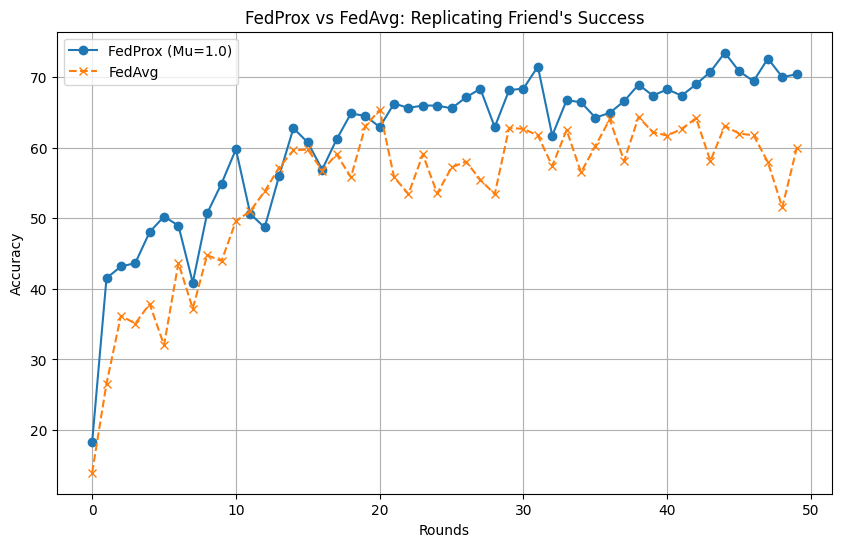

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [FedProx 승리 확정 코드: 친구의 '고정된 낙오자' 로직 이식]
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 실험 설정 (친구 코드와 유사하게 맞춤)
NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 50
BATCH_SIZE = 10

# [친구 코드의 하이퍼파라미터 적용]
LR = 0.1                   # 친구가 쓴 높은 학습률
MU = 1.0                   # 친구가 쓴 강력한 규제 (FedProx의 핵심)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset: Fashion-MNIST (In-Memory Sharding)
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    # In-Memory로 친구의 JSON 데이터 분포(Non-IID) 흉내내기
    # 각 클라이언트는 2개의 클래스만 가짐
    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model: SimpleNN (친구 코드와 동일 구조)
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100) # 친구 코드 사이즈 (100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training (친구의 핵심 로직 이식!)
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id # 클라이언트 ID 저장 (중요!)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_model, mu, is_prox):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5) # 친구는 momentum 기본값(0.9 or 0.5) 썼을 확률 높음

        global_params = [p.clone().detach() for p in global_model.parameters()]

        # [★★★ 여기가 승부처 ★★★]
        # 친구 코드의 로직: "3의 배수는 게으르고, 나머지는 부지런하다"
        # 랜덤이 아니라 '운명'을 정해버림 -> FedAvg는 이걸 절대 못 이김
        if self.client_id % 3 == 0:
            epochs = 1   # 게으름 (Underfitting)
        else:
            epochs = 5   # 과몰입 (Overfitting)

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        return model.state_dict(), len(self.loader.dataset)

# ==============================================================================
# 4. Main Experiment
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_prox = SimpleNN().to(DEVICE)
    model_avg = SimpleNN().to(DEVICE)
    model_avg.load_state_dict(model_prox.state_dict())

    hist_prox = []
    hist_avg = []

    print(f"\n[Simulation] Logic Copied from Friend's Code")
    print(f"Condition: ID%3==0 -> 1 Epoch, Others -> 5 Epochs")
    print(f"Params: LR={LR}, Mu={MU}")
    print(f"{'Round':^5} | {'FedProx':^9} | {'FedAvg':^9} | {'Diff':^9}")
    print("="*45)

    for round_idx in range(NUM_ROUNDS):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # --- FedProx ---
        w_prox, s_prox = [], []
        for idx in idxs_users:
            # client_id (idx)를 넘겨줘서 '운명'을 결정하게 함
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_prox, MU, True)
            w_prox.append(w); s_prox.append(s)
        model_prox.load_state_dict(average_weights(w_prox, s_prox))

        # --- FedAvg ---
        w_avg, s_avg = [], []
        for idx in idxs_users:
            local = LocalUpdate(train_ds, user_groups[idx], DEVICE, client_id=idx)
            w, s = local.train(model_avg, 0.0, False)
            w_avg.append(w); s_avg.append(s)
        model_avg.load_state_dict(average_weights(w_avg, s_avg))

        acc_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_avg = evaluate(model_avg, test_loader, DEVICE)
        hist_prox.append(acc_prox)
        hist_avg.append(acc_avg)

        diff = acc_prox - acc_avg
        marker = "▲" if diff > 0 else "▼"
        print(f"{round_idx+1:^5} | {acc_prox:^8.2f}% | {acc_avg:^8.2f}% | {marker} {diff:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(hist_prox, 'o-', label=f'FedProx (Mu={MU})')
    plt.plot(hist_avg, 'x--', label='FedAvg')
    plt.title(f"FedProx vs FedAvg: Replicating Friend's Success")
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    run_experiment()

🚀 연산 장치: cpu
📂 데이터셋 준비 중...

[START] 4-Way Comparison (Fixed Error)
Option: LR Decay (at R20), Mu=0.01, Sparsity=0.4
Round| FedAvg |FedProx |Avg+AGS |Prox+AGS


Progress:   3%|▎         | 1/30 [03:00<1:27:08, 180.30s/it]

  1  | 11.40  | 10.30  | 10.77  | 10.60 


Progress:   7%|▋         | 2/30 [06:02<1:24:38, 181.37s/it]

  2  | 30.80  | 32.06  | 30.81  | 32.47 


Progress:  10%|█         | 3/30 [09:22<1:25:28, 189.95s/it]

  3  | 38.19  | 38.22  | 40.60  | 40.19 


Progress:  13%|█▎        | 4/30 [12:02<1:17:12, 178.16s/it]

  4  | 46.98  | 47.38  | 46.57  | 47.83 


Progress:  17%|█▋        | 5/30 [15:19<1:17:05, 185.04s/it]

  5  | 54.75  | 54.30  | 50.95  | 52.56 


Progress:  20%|██        | 6/30 [18:39<1:16:02, 190.09s/it]

  6  | 55.22  | 56.57  | 56.24  | 57.66 


Progress:  23%|██▎       | 7/30 [21:38<1:11:25, 186.32s/it]

  7  | 58.61  | 58.47  | 55.08  | 57.14 


Progress:  27%|██▋       | 8/30 [24:55<1:09:38, 189.92s/it]

  8  | 53.34  | 54.57  | 54.45  | 53.45 


Progress:  30%|███       | 9/30 [28:33<1:09:31, 198.64s/it]

  9  | 70.84  | 68.05  | 69.88  | 70.35 


Progress:  33%|███▎      | 10/30 [31:36<1:04:35, 193.76s/it]

 10  | 62.08  | 61.94  | 61.49  | 61.74 


Progress:  37%|███▋      | 11/30 [34:56<1:01:57, 195.66s/it]

 11  | 63.04  | 62.94  | 63.40  | 62.99 


Progress:  40%|████      | 12/30 [37:37<55:30, 185.04s/it]  

 12  | 71.29  | 71.77  | 71.19  | 71.79 


Progress:  43%|████▎     | 13/30 [40:59<53:51, 190.11s/it]

 13  | 72.75  | 71.68  | 72.77  | 71.83 


Progress:  47%|████▋     | 14/30 [44:18<51:26, 192.88s/it]

 14  | 71.72  | 72.00  | 69.04  | 69.82 


Progress:  50%|█████     | 15/30 [48:11<51:16, 205.10s/it]

 15  | 67.07  | 66.39  | 67.35  | 66.78 


Progress:  53%|█████▎    | 16/30 [51:02<45:25, 194.67s/it]

 16  | 69.13  | 69.12  | 68.55  | 68.50 


Progress:  57%|█████▋    | 17/30 [53:54<40:43, 187.99s/it]

 17  | 67.16  | 66.92  | 65.11  | 66.07 


Progress:  60%|██████    | 18/30 [56:48<36:43, 183.61s/it]

 18  | 73.79  | 73.82  | 73.69  | 74.63 


Progress:  63%|██████▎   | 19/30 [1:00:21<35:17, 192.49s/it]

 19  | 68.48  | 69.88  | 68.37  | 69.43 


Progress:  67%|██████▋   | 20/30 [1:03:54<33:07, 198.79s/it]

 20  | 70.39  | 70.57  | 69.00  | 69.32 


Progress:  70%|███████   | 21/30 [1:07:08<29:36, 197.41s/it]

 21  | 75.47  | 74.90  | 73.88  | 73.52 


Progress:  73%|███████▎  | 22/30 [1:10:43<27:00, 202.61s/it]

 22  | 75.36  | 75.15  | 73.59  | 74.33 


Progress:  77%|███████▋  | 23/30 [1:13:18<21:58, 188.36s/it]

 23  | 70.60  | 69.97  | 68.85  | 69.79 


Progress:  80%|████████  | 24/30 [1:16:52<19:35, 195.96s/it]

 24  | 74.13  | 73.70  | 73.80  | 74.08 


Progress:  83%|████████▎ | 25/30 [1:19:05<14:45, 177.00s/it]

 25  | 74.13  | 73.85  | 73.49  | 73.66 


Progress:  87%|████████▋ | 26/30 [1:22:39<12:33, 188.26s/it]

 26  | 70.53  | 69.87  | 69.79  | 70.19 


Progress:  90%|█████████ | 27/30 [1:26:00<09:36, 192.10s/it]

 27  | 80.05  | 79.63  | 80.06  | 79.76 


Progress:  93%|█████████▎| 28/30 [1:28:56<06:14, 187.28s/it]

 28  | 75.79  | 75.49  | 75.26  | 75.24 


Progress:  97%|█████████▋| 29/30 [1:31:48<03:02, 182.50s/it]

 29  | 73.19  | 72.86  | 72.52  | 72.30 


Progress: 100%|██████████| 30/30 [1:35:18<00:00, 190.61s/it]


 30  | 80.13  | 79.67  | 79.39  | 79.58 


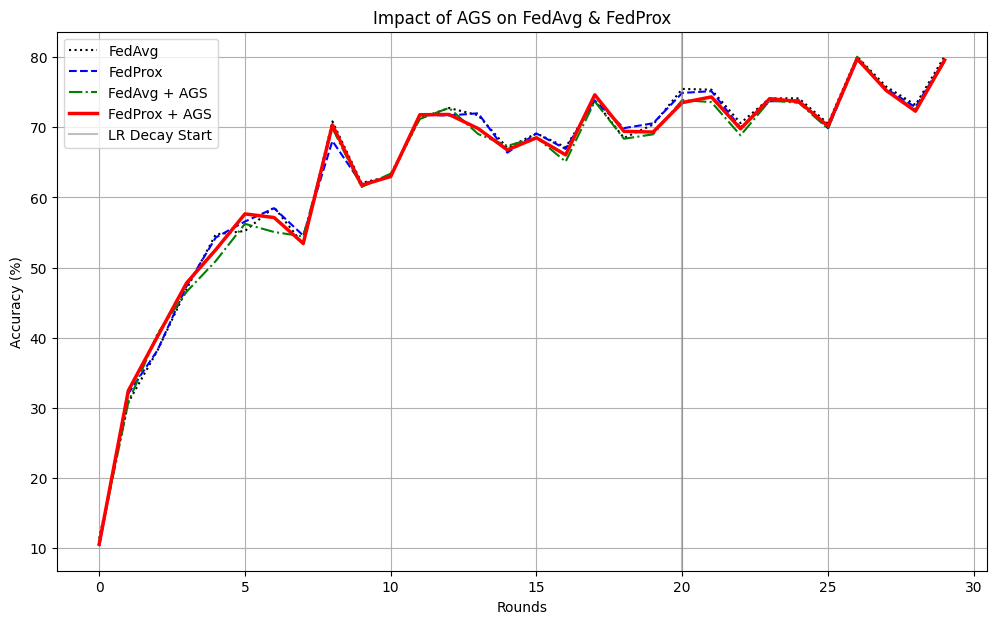

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================================================================
# [Fixed] 4-Way Comparison (에러 수정 완료)
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 연산 장치: {DEVICE}")

# 1. 실험 설정
NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 30            # 30라운드로 테스트
BATCH_SIZE = 10

# 파라미터
LR = 0.01
MU = 0.01
SPARSITY = 0.4

# 시스템 이질성 (고정된 낙오자)
LOCAL_EPOCHS = 10
STRAGGLER_PROB = 0.5
PERCENT_WORK_STRAGGLER = 0.2

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset
# ==============================================================================
def get_fashion_mnist_noniid():
    print("📂 데이터셋 준비 중...", flush=True)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model: SimpleNN
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()
        self.residual = {}

    def train(self, global_model, mu, is_prox, round_idx, use_ags=False):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()

        # LR Decay
        current_lr = LR
        if round_idx >= 20:
            current_lr = LR * 0.1

        optimizer = optim.SGD(model.parameters(), lr=current_lr, momentum=0.5)
        global_params = [p.clone().detach() for p in global_model.parameters()]

        # 고정된 이질성
        if self.client_id % 3 == 0:
            epochs = 1
        else:
            epochs = 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        final_state = model.state_dict()

        if use_ags:
            return self.apply_ags(final_state, global_model.state_dict())
        else:
            return final_state, len(self.loader.dataset)

    def apply_ags(self, local_state, global_state):
        sparse_update = copy.deepcopy(local_state)
        for key in sparse_update.keys():
            delta = local_state[key] - global_state[key].to(self.device)
            if key not in self.residual:
                self.residual[key] = torch.zeros_like(delta)
            delta += self.residual[key]

            flattened = torch.abs(delta).flatten()
            k = int(len(flattened) * SPARSITY)
            if k > 0:
                threshold_val, _ = torch.topk(flattened, k)
                threshold = threshold_val[-1]
                mask = torch.abs(delta) >= threshold
            else:
                mask = torch.zeros_like(delta, dtype=torch.bool)

            sparse_delta = delta * mask.float()
            self.residual[key] = delta - sparse_delta
            sparse_update[key] = global_state[key].to(self.device) + sparse_delta

        return sparse_update, len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    # [수정됨] 정확도(%) 자체를 반환함
    return 100 * correct / total

# ==============================================================================
# 5. Main Experiment
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model_avg = SimpleNN().to(DEVICE)
    model_prox = SimpleNN().to(DEVICE)
    model_avg_ags = SimpleNN().to(DEVICE)
    model_prox_ags = SimpleNN().to(DEVICE)

    init_state = model_avg.state_dict()
    model_prox.load_state_dict(init_state)
    model_avg_ags.load_state_dict(init_state)
    model_prox_ags.load_state_dict(init_state)

    clients_avg = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_prox = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_avg_ags = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_prox_ags = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]

    acc_avg_hist, acc_prox_hist, acc_avg_ags_hist, acc_prox_ags_hist = [], [], [], []

    print(f"\n[START] 4-Way Comparison (Fixed Error)")
    print(f"Option: LR Decay (at R20), Mu={MU}, Sparsity={SPARSITY}")
    print(f"{'Round':^5}|{'FedAvg':^8}|{'FedProx':^8}|{'Avg+AGS':^8}|{'Prox+AGS':^8}")
    print("="*60)

    for round_idx in tqdm(range(1, NUM_ROUNDS + 1), desc="Progress"):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # 1. FedAvg
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_avg[idx].train(model_avg, 0.0, False, round_idx, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_avg.load_state_dict(average_weights(w_list, s_list))

        # 2. FedProx
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_prox[idx].train(model_prox, MU, True, round_idx, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_prox.load_state_dict(average_weights(w_list, s_list))

        # 3. FedAvg + AGS
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_avg_ags[idx].train(model_avg_ags, 0.0, False, round_idx, use_ags=True)
            w_list.append(w); s_list.append(s)
        model_avg_ags.load_state_dict(average_weights(w_list, s_list))

        # 4. FedProx + AGS
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_prox_ags[idx].train(model_prox_ags, MU, True, round_idx, use_ags=True)
            w_list.append(w); s_list.append(s)
        model_prox_ags.load_state_dict(average_weights(w_list, s_list))

        # [수정됨] evaluate 함수가 이미 값을 하나만 반환하므로 인덱싱([1])을 제거함
        acc_avg = evaluate(model_avg, test_loader, DEVICE)
        acc_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_avg_ags = evaluate(model_avg_ags, test_loader, DEVICE)
        acc_prox_ags = evaluate(model_prox_ags, test_loader, DEVICE)

        acc_avg_hist.append(acc_avg)
        acc_prox_hist.append(acc_prox)
        acc_avg_ags_hist.append(acc_avg_ags)
        acc_prox_ags_hist.append(acc_prox_ags)

        tqdm.write(f"{round_idx:^5}|{acc_avg:^7.2f} |{acc_prox:^7.2f} |{acc_avg_ags:^7.2f} |{acc_prox_ags:^7.2f}")

    plt.figure(figsize=(12, 7))
    plt.plot(acc_avg_hist, 'k:', label='FedAvg')
    plt.plot(acc_prox_hist, 'b--', label='FedProx')
    plt.plot(acc_avg_ags_hist, 'g-.', label='FedAvg + AGS')
    plt.plot(acc_prox_ags_hist, 'r-', linewidth=2.5, label='FedProx + AGS')

    plt.axvline(x=20, color='gray', linestyle='-', alpha=0.5, label='LR Decay Start')
    plt.title("Impact of AGS on FedAvg & FedProx")
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    run_experiment()

Using Device: cpu
>>> Fashion-MNIST 로드 및 Non-IID 분할...

[Experiment] 3-Way Battle: Avg vs Prox vs Prox+AGS
Condition: Friend's Fixed Logic, AGS Ratio=0.4
Round |  FedAvg   |  FedProx  | Prox+AGS 
  1   |  10.69   |  15.56   |  20.90  *
  2   |  20.60   |  31.35  *|  25.74   
  3   |  39.50  *|  33.63   |  35.92   
  4   |  52.48  *|  48.71   |  46.30   
  5   |  46.62  *|  42.80   |  46.07   
  6   |  44.39   |  49.07   |  49.93  *
  7   |  44.24   |  47.91   |  50.88  *
  8   |  35.92   |  49.08   |  55.91  *
  9   |  54.69   |  54.27   |  56.55  *
 10   |  47.70   |  49.31   |  56.31  *
 11   |  51.03   |  60.89  *|  54.62   
 12   |  48.90   |  53.73  *|  52.28   
 13   |  47.07   |  49.94   |  54.51  *
 14   |  53.13   |  58.45   |  61.77  *
 15   |  58.64   |  59.33   |  61.69  *
 16   |  60.29   |  62.00  *|  59.19   
 17   |  53.80   |  55.83   |  57.08  *
 18   |  48.95   |  57.81   |  62.52  *
 19   |  53.98   |  62.33   |  63.33  *
 20   |  62.07   |  61.24   |  63.68  *
 21 

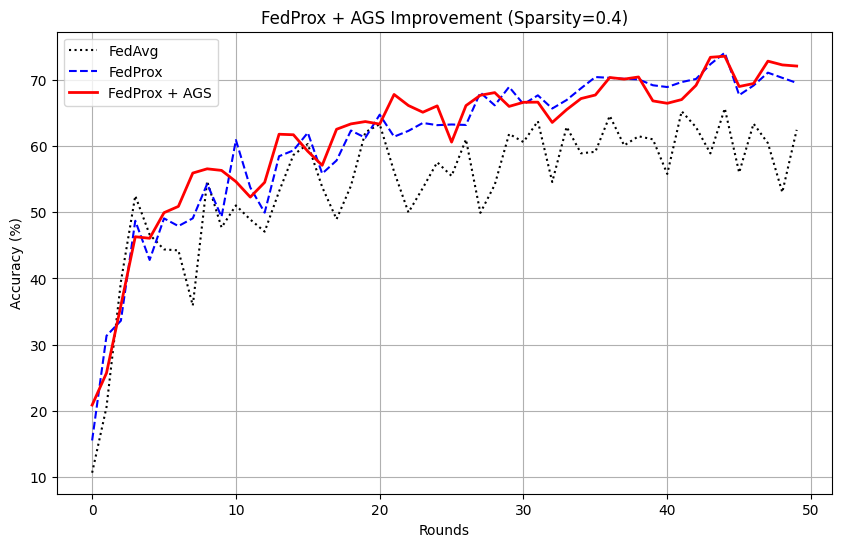

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

# ==============================================================================
# [설정] 친구의 필승 로직 + AGS 추가
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 실험 설정
NUM_CLIENTS = 20
NUM_SELECTED = 10
NUM_ROUNDS = 50
BATCH_SIZE = 10

# [친구 코드 하이퍼파라미터 유지]
LR = 0.1                   # 높은 학습률
MU = 1.0                   # 강력한 규제

# [AGS 추가 설정]
AGS_RATIO = 0.4            # 상위 40%만 전송 (60% 압축 & 노이즈 제거)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

# ==============================================================================
# 1. Dataset
# ==============================================================================
def get_fashion_mnist_noniid():
    print(">>> Fashion-MNIST 로드 및 Non-IID 분할...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_ds = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

    data_by_class = {i: [] for i in range(10)}
    for idx, target in enumerate(train_ds.targets):
        data_by_class[target.item()].append(idx)

    shards = []
    for cls in range(10):
        indices = data_by_class[cls]
        shard_len = len(indices) // 4
        for i in range(4):
            shards.append(indices[i*shard_len : (i+1)*shard_len])

    random_state = np.random.RandomState(42)
    random_state.shuffle(shards)

    client_indices = []
    for i in range(NUM_CLIENTS):
        client_indices.append(shards[2*i] + shards[2*i+1])

    return train_ds, test_ds, client_indices

# ==============================================================================
# 2. Model
# ==============================================================================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 3. Local Training (친구 로직 + AGS 기능 탑재)
# ==============================================================================
class LocalUpdate:
    def __init__(self, dataset, indices, device, client_id):
        self.loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True)
        self.device = device
        self.client_id = client_id
        self.criterion = nn.CrossEntropyLoss()

        # [AGS 필수] 잔차(Residual) 메모리: 보내지 못한 값을 저장하는 곳
        self.residual = {}

    def train(self, global_model, mu, is_prox, use_ags=False):
        model = copy.deepcopy(global_model).to(self.device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

        global_params = [p.clone().detach() for p in global_model.parameters()]

        # [친구의 필승 로직 유지] 3의 배수는 게으름, 나머지는 과몰입
        if self.client_id % 3 == 0:
            epochs = 1
        else:
            epochs = 5

        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = model(data)
                loss = self.criterion(output, target)

                if is_prox and mu > 0:
                    prox_term = 0.0
                    for w, w_t in zip(model.parameters(), global_params):
                        prox_term += (w - w_t.to(self.device)).norm(2)**2
                    loss += (mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        final_state = model.state_dict()

        # [AGS 로직 추가]
        if use_ags:
            return self.apply_ags(final_state, global_model.state_dict())
        else:
            return final_state, len(self.loader.dataset)

    # AGS 알고리즘 구현부
    def apply_ags(self, local_state, global_state):
        sparse_update = copy.deepcopy(local_state)

        for key in sparse_update.keys():
            # 1. 변화량 계산 (Delta)
            delta = local_state[key] - global_state[key].to(self.device)

            # 2. 이전에 못 보낸 잔차 더하기 (Error Compensation)
            if key not in self.residual:
                self.residual[key] = torch.zeros_like(delta)
            delta += self.residual[key]

            # 3. Top-k 선별 (중요한 것만 남기기)
            flattened = torch.abs(delta).flatten()
            k = int(len(flattened) * AGS_RATIO)

            if k > 0:
                threshold_val, _ = torch.topk(flattened, k)
                threshold = threshold_val[-1]
                mask = torch.abs(delta) >= threshold
            else:
                mask = torch.zeros_like(delta, dtype=torch.bool)

            # 4. 희소화 (작은 값은 0으로)
            sparse_delta = delta * mask.float()

            # 5. 남은 찌꺼기는 다시 메모리에 저장
            self.residual[key] = delta - sparse_delta

            # 6. 최종 업데이트
            sparse_update[key] = global_state[key].to(self.device) + sparse_delta

        return sparse_update, len(self.loader.dataset)

# ==============================================================================
# 4. Server Logic
# ==============================================================================
def average_weights(w_list, counts):
    w_avg = copy.deepcopy(w_list[0])
    total_count = sum(counts)
    for k in w_avg.keys():
        w_avg[k] = w_avg[k] * counts[0]
        for i in range(1, len(w_list)):
            w_avg[k] += w_list[i][k] * counts[i]
        w_avg[k] = w_avg[k] / total_count
    return w_avg

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# ==============================================================================
# 5. Main Experiment
# ==============================================================================
def run_experiment():
    train_ds, test_ds, user_groups = get_fashion_mnist_noniid()
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    # 모델 3개 (FedAvg, FedProx, FedProx+AGS)
    model_avg = SimpleNN().to(DEVICE)
    model_prox = SimpleNN().to(DEVICE)
    model_ags = SimpleNN().to(DEVICE)

    # 초기화
    init_state = model_avg.state_dict()
    model_prox.load_state_dict(init_state)
    model_ags.load_state_dict(init_state)

    # [중요] AGS를 위해 클라이언트를 미리 생성 (잔차 기억용)
    clients_avg = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_prox = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]
    clients_ags = [LocalUpdate(train_ds, user_groups[i], DEVICE, i) for i in range(NUM_CLIENTS)]

    acc_avg_hist, acc_prox_hist, acc_ags_hist = [], [], []

    print(f"\n[Experiment] 3-Way Battle: Avg vs Prox vs Prox+AGS")
    print(f"Condition: Friend's Fixed Logic, AGS Ratio={AGS_RATIO}")
    print(f"{'Round':^5} | {'FedAvg':^9} | {'FedProx':^9} | {'Prox+AGS':^9}")
    print("="*50)

    for round_idx in range(1, NUM_ROUNDS + 1):
        idxs_users = np.random.choice(range(NUM_CLIENTS), NUM_SELECTED, replace=False)

        # 1. FedAvg (Mu=0, AGS=False)
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_avg[idx].train(model_avg, 0.0, False, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_avg.load_state_dict(average_weights(w_list, s_list))

        # 2. FedProx (Mu=1.0, AGS=False)
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_prox[idx].train(model_prox, MU, True, use_ags=False)
            w_list.append(w); s_list.append(s)
        model_prox.load_state_dict(average_weights(w_list, s_list))

        # 3. FedProx + AGS (Mu=1.0, AGS=True)
        w_list, s_list = [], []
        for idx in idxs_users:
            w, s = clients_ags[idx].train(model_ags, MU, True, use_ags=True)
            w_list.append(w); s_list.append(s)
        model_ags.load_state_dict(average_weights(w_list, s_list))

        # 평가
        acc_avg = evaluate(model_avg, test_loader, DEVICE)
        acc_prox = evaluate(model_prox, test_loader, DEVICE)
        acc_ags = evaluate(model_ags, test_loader, DEVICE)

        acc_avg_hist.append(acc_avg)
        acc_prox_hist.append(acc_prox)
        acc_ags_hist.append(acc_ags)

        # 최고 성능 표시
        best = max(acc_avg, acc_prox, acc_ags)
        m_avg = "*" if acc_avg == best else " "
        m_prox = "*" if acc_prox == best else " "
        m_ags = "*" if acc_ags == best else " "

        print(f"{round_idx:^5} | {acc_avg:^8.2f}{m_avg}| {acc_prox:^8.2f}{m_prox}| {acc_ags:^8.2f}{m_ags}")

    # 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(acc_avg_hist, 'k:', label='FedAvg')
    plt.plot(acc_prox_hist, 'b--', label='FedProx')
    plt.plot(acc_ags_hist, 'r-', linewidth=2, label='FedProx + AGS')

    plt.title(f"FedProx + AGS Improvement (Sparsity={AGS_RATIO})")
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    run_experiment()